In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import math
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rc('font', **font)
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import datetime as dt
import joblib
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from datetime import datetime

In [2]:
def line(x, a, b):
    #Basic straight line equation
	return a * x + b

In [3]:
def second_degree(x, a, b, c):
    return a*x**2 + b*x + c

In [4]:
def get_start_end_unix(df, start, end):
    return df.loc[(pd.Timestamp(start) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'):(pd.Timestamp(end) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')]

In [40]:
def Time_to_Fail(df, target):
    popt_line, _ = curve_fit(line, (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'),df['Inlet Filter Differential Pressure (bar)'])
    # summarize the parameter values
    a_line, b_line = popt_line
    unix_times_line = (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    y_line = line(unix_times_line, a_line, b_line)
    line_day = int((target-b_line)/a_line)
    print('Linear Pred: '+datetime.utcfromtimestamp(line_day).strftime('%Y-%m-%d %H:%M:%S'))
    if datetime.utcfromtimestamp(line_day)<df.index.min():
        trending = "Down"
    else:
        trending = 'Up'
    print('Trending: '+trending)
    poly_day = 0
    
    popt_max, _ = curve_fit(second_degree, (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'),df['Inlet Filter Differential Pressure (bar)'],  maxfev=5000)
    # summarize the parameter values
    a_max, b_max, c_max = popt_max
    y_max = second_degree(unix_times_line, a_max, b_max, c_max)
    plt.plot(unix_times_line, y_max, color = 'tab:orange')
    try:
        poly_day = int((math.sqrt((-4*a_max*c_max)+(4*a_max*target)+(b_max**2))-b_max)/(2*a_max))
    except ValueError:
        print('No Poly Reading')
    else:
        #plt.scatter((df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'),df['Inlet Filter Differential Pressure (bar)'])
        print('Poly Pred: '+datetime.utcfromtimestamp(poly_day).strftime('%Y-%m-%d %H:%M:%S'))
        plt.scatter(poly_day,target, color='tab:orange', marker='X', s =250)
        plt.plot([unix_times_line[-1],poly_day],[y_max[-1],target], color = 'tab:orange',linestyle= '--')

        if trending=='Up':
            plt.plot(unix_times_line, y_line, color = 'r')
            

            plt.scatter(line_day,target, color = 'r', marker='v', s =250)
            plt.plot([unix_times_line[-1],line_day],[y_line[-1],target], color = 'r', linestyle= '--')

            min_max = [line_day, poly_day]
            mid_day = min(min_max)+((max(min_max)-min(min_max))/2)
            print(datetime.utcfromtimestamp(mid_day).strftime('%Y-%m-%d %H:%M:%S'))
            plt.scatter(mid_day, target, color='g', marker = '.', s=250)
        plt.scatter(unix_times_line,df['Inlet Filter Differential Pressure (bar)'], label = df.labels.max())
    return a_max, b_max, c_max, poly_day

In [6]:
def Time_to_Fail_VEAS(df, target):
    popt_line, _ = curve_fit(line, (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'),df['Inlet Filter dp (Pa)'])
    # summarize the parameter values
    a_line, b_line = popt_line
    unix_times_line = (df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    y_line = line(unix_times_line, a_line, b_line)
    plt.plot(unix_times_line, y_line, color = 'r')
    plt.scatter(unix_times_line,df['Inlet Filter dp (Pa)'])
    line_day = int((target-b_line)/a_line)
    print('Linear Pred: '+datetime.utcfromtimestamp(line_day).strftime('%Y-%m-%d %H:%M:%S'))
    if datetime.utcfromtimestamp(line_day)<df.index.min():
        trending = "Down"
    else:
        trending = 'Up'
    print('Trending: '+trending)
    plt.scatter(line_day,target, color = 'r', marker='v', s =250)
    plt.plot([unix_times_line[-1],line_day],[y_line[-1],target], color = 'r', linestyle= '--')
    
    popt_max, _ = curve_fit(second_degree, unix_times_line,df['Inlet Filter dp (Pa)'],  maxfev=5000)
    # summarize the parameter values
    a_max, b_max, c_max = popt_max
    y_max = second_degree(unix_times_line, a_max, b_max, c_max)
    plt.plot(unix_times_line, y_max, color = 'tab:orange')
    poly_day = int((math.sqrt((-4*a_max*c_max)+(4*a_max*target)+(b_max**2))-b_max)/(2*a_max))
    #plt.scatter((df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'),df['Inlet Filter Differential Pressure (bar)'])
    print('Poly Pred: '+datetime.utcfromtimestamp(poly_day).strftime('%Y-%m-%d %H:%M:%S'))
    plt.scatter(poly_day,target, color='tab:orange', marker='X', s =250)
    plt.plot([unix_times_line[-1],poly_day],[y_max[-1],target], color = 'tab:orange',linestyle= '--')
    

In [59]:
def All_times_to_fail(df, target):
    results = []
    counts = []
    for x in list(df.labels.unique()):
        print(x)
        results.append(Time_to_Fail(df[df['labels']==x], target)[3])
        counts.append(df[df['labels']==x].shape[0])
    return results, counts

In [8]:
df= pd.read_csv('K_means_air_filter.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d', errors='ignore')
df = df.set_index('timestamp')
dp_df = df[['Inlet Filter Differential Pressure (bar)']].dropna()

In [9]:
df_veas= pd.read_csv('K_means_air_filter_VEAS.csv')
df_veas['timestamp'] = pd.to_datetime(df_veas['timestamp'], format='%Y-%m-%d', errors='ignore')
df_veas = df_veas.set_index('timestamp')
#df_val = df_val[['Inlet Filter Differential Pressure (bar)']].dropna()

In [10]:
df_val= pd.read_csv('K_means_air_filter_val.csv')
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'], format='%Y-%m-%d', errors='ignore')
df_val = df_val.set_index('timestamp')
#df_val = df_val[['Inlet Filter Differential Pressure (bar)']].dropna()

In [11]:

df_val_2= pd.read_csv('K_means_air_filter_3.csv')
df_val_2['timestamp'] = pd.to_datetime(df_val_2['timestamp'], format='%Y-%m-%d', errors='ignore')
df_val_2 = df_val_2.set_index('timestamp')
#df_val = df_val[['Inlet Filter Differential Pressure (bar)']].dropna()

In [12]:
df_val_3 = pd.read_csv('K_means_air_filter_4_Tom_val.csv')
df_val_3['timestamp'] = pd.to_datetime(df_val_3['timestamp'], format='%Y-%m-%d', errors='ignore')
df_val_3 = df_val_3.set_index('timestamp')
#df_val = df_val[['Inlet Filter Differential Pressure (bar)']].dropna()

Linear Pred: 2022-07-07 22:47:13
Trending: Up
Poly Pred: 2021-12-15 16:35:13
2022-03-27 19:41:13


<function matplotlib.pyplot.legend(*args, **kwargs)>

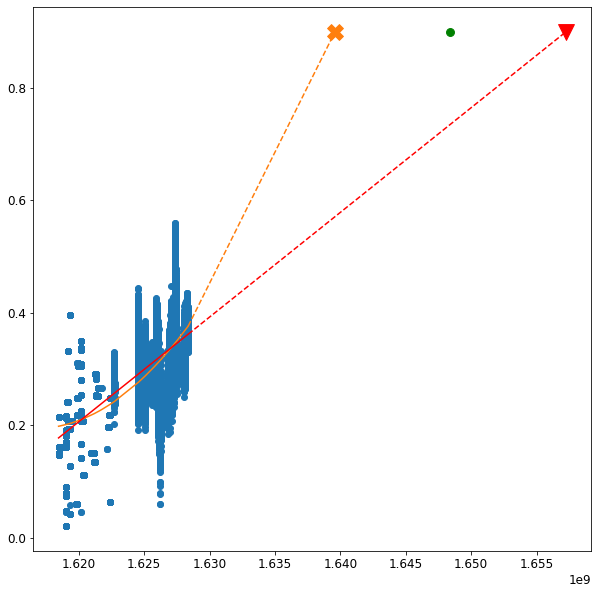

In [13]:
a, b, c = Time_to_Fail(df[df['labels']==2], .9)
plt.legend

In [14]:
a, b, c

(1.3582924310350831e-15, -4.392158942210014e-06, 3550.8032015177982)

Poly Pred: 2022-04-19 05:52:25


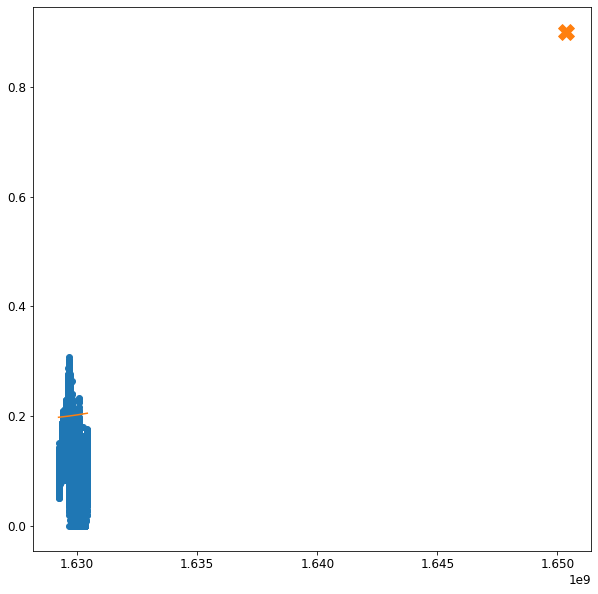

In [15]:
target = 0.9
delta = ((df_val_2.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))[0]-((df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))[0]
y_test = second_degree(((df_val_2.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))-delta, a, b, c)
plt.scatter((df_val_2.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'),df_val_2['Inlet Filter Differential Pressure (bar)'])
plt.plot(((df_val_2.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')), y_test, color = 'tab:orange')

poly_target = int((math.sqrt((-4*a*c)+(4*a*target)+(b**2))-b)/(2*a))+delta
print('Poly Pred: '+datetime.utcfromtimestamp(poly_target).strftime('%Y-%m-%d %H:%M:%S'))
plt.scatter(poly_target,target, color='tab:orange', marker='X', s =250)

In [16]:
((df_val_2.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))[0]-((df.index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))[0]

10761432

In [17]:
datetime.utcfromtimestamp(int(-4.438461281591139e-06)).strftime('%Y-%m-%d %H:%M:%S')

'1970-01-01 00:00:00'

2
Linear Pred: 2021-11-01 12:52:31
Trending: Up
Poly Pred: 2021-09-16 12:00:08
2021-10-09 12:26:19
1
Linear Pred: 2023-10-09 00:50:22
Trending: Up
Poly Pred: 2023-02-26 16:02:57
2023-06-18 20:26:39
3
Linear Pred: 2047-03-24 15:23:04
Trending: Up
Poly Pred: 2022-09-12 17:43:29
2034-12-18 04:33:16


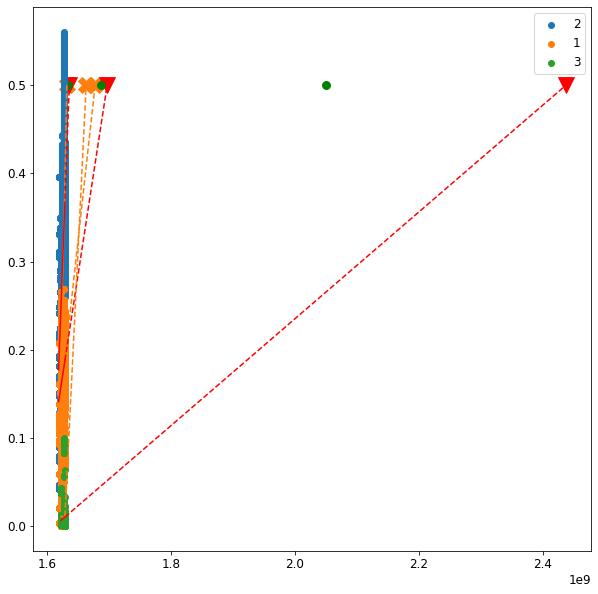

In [18]:
All_times_to_fail(df[df['labels']!=0], 0.5)
plt.legend()

2
Linear Pred: 2020-02-12 14:06:05
Trending: Down
Poly Pred: 2021-11-19 16:51:05
3
Linear Pred: 2021-04-15 01:56:23
Trending: Down
No Poly Reading
1
Linear Pred: 2021-07-08 07:14:45
Trending: Down
Poly Pred: 2021-08-30 18:04:51


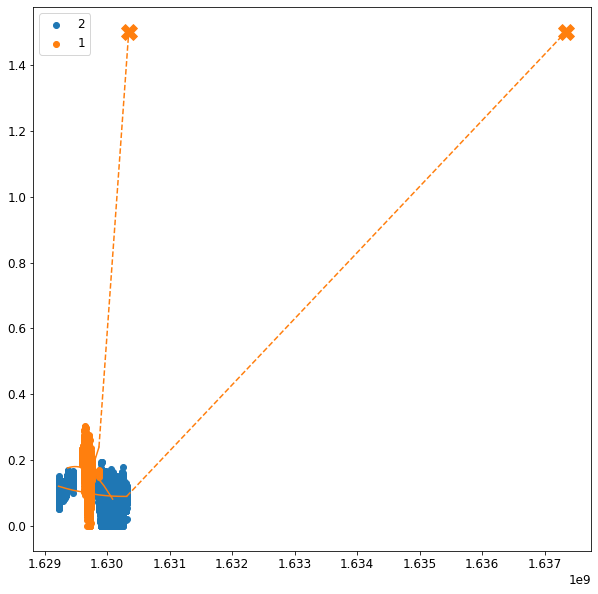

In [60]:
all_results, counts = All_times_to_fail(df_val, 1.5)
plt.legend()

In [61]:
all_results

[1637340665, 0, 1630346691]

In [62]:
counts

[124333, 97446, 31089]

In [63]:
max(counts)/(counts[0]+counts[2])

0.7999704031604278

In [70]:
int((all_results[0]-all_results[2])*(max(counts)/(counts[0]+counts[2])))

5594972

In [72]:
datetime.utcfromtimestamp(all_results[2]+int((all_results[0]-all_results[2])*(max(counts)/(counts[0]+counts[2])))).strftime('%Y-%m-%d %H:%M:%S')

'2021-11-03 12:14:23'

2
Linear Pred: 2020-08-20 07:51:50
Trending: Down
No Poly Reading
1
Linear Pred: 2020-02-03 08:49:16
Trending: Down
Poly Pred: 2021-10-07 00:02:10
3
Linear Pred: 2020-08-05 03:05:06
Trending: Down
Poly Pred: 2021-10-16 23:19:59
0
Linear Pred: 2021-03-04 14:59:18
Trending: Down
No Poly Reading


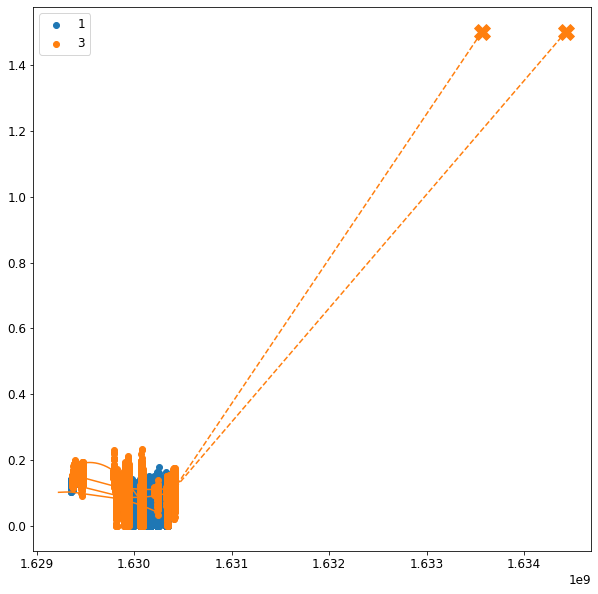

In [20]:
All_times_to_fail(df_val_2, 1.5)
plt.legend()

Linear Pred: 2021-07-25 10:53:11
Trending: Down
No Poly Reading


(-4.149285368703428e-13, 0.001352286793101484, -1101803.7371768511)

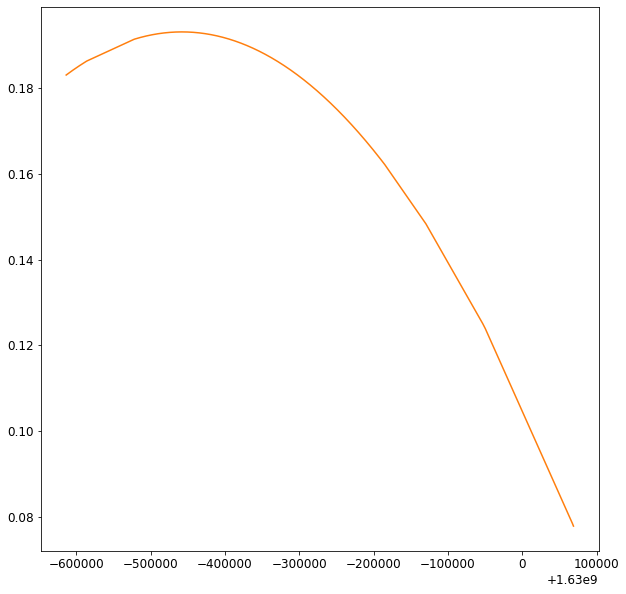

In [21]:
Time_to_Fail(df_val_2.loc[df_val_2['labels']==0], .4)

Linear Pred: 2044-05-13 07:19:50
Trending: Up
Poly Pred: 2021-04-20 12:01:27


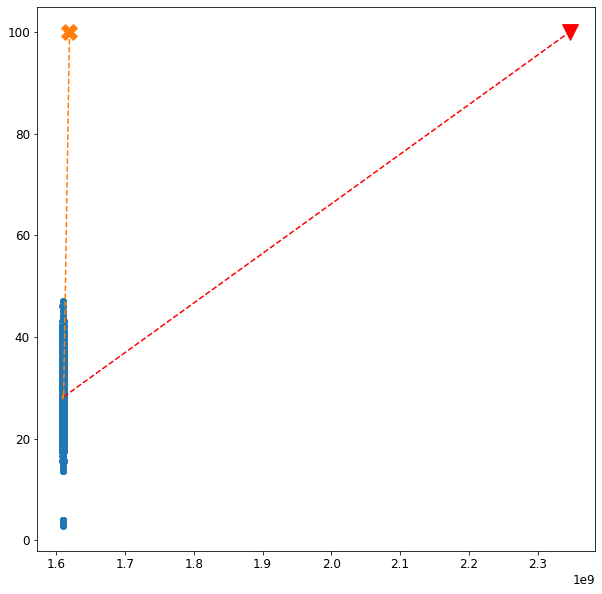

In [22]:
Time_to_Fail_VEAS(df_veas[df_veas['labels']==2]['2020-12-23':'2021-01-12'], 100)

In [23]:
df_veas

,MDM current (A),Actual Volume Flow (Nm3/hr),VDV Pos [%] (%),IGV Pos [%] (%),Inlet Filter dp (Pa),Relative Polytropic Efficiency [%] (%),labels
timestamp,,,,,,,
2020-12-23 03:22:06.149,675.0,4.143189,70.0,76.0,30.400614,0.0,1
2020-12-23 03:22:06.154,675.0,4.024575,70.0,76.0,30.400614,0.0,1
2020-12-23 03:22:06.159,675.0,4.132911,70.0,76.0,30.400614,0.0,1
2020-12-23 03:22:06.164,675.0,4.098188,70.0,76.0,30.400614,0.0,1
2020-12-23 03:22:06.169,675.0,4.095410,70.0,76.0,30.400614,0.0,1
...,...,...,...,...,...,...,...
2021-03-23 23:59:47.458,689.0,4.008976,90.0,76.0,93.163177,0.0,1
2021-03-23 23:59:52.458,689.0,4.008976,90.0,76.0,94.143837,0.0,1
2021-03-23 23:59:57.459,689.0,4.008976,90.0,76.0,86.298523,0.0,1


Linear Pred: 2021-08-19 20:34:53
Trending: Up
Poly Pred: 2021-04-12 03:21:57


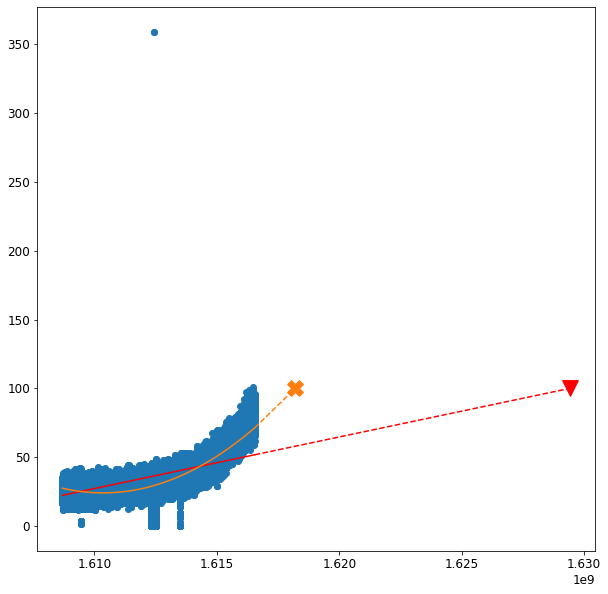

In [24]:
Time_to_Fail_VEAS(df_veas[df_veas['labels']==0], 100)